In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,make_scorer,f1_score,recall_score,precision_score
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance

import eli5
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
from sklearn.metrics import accuracy_score,roc_auc_score,make_scorer,f1_score,recall_score,precision_score

# What's in the dateset ?

#### Source : IBM Sample dataset

IBM provided customer data for Telecom industry to predict churn customer based on demographic, usage and account based information. Main objective here is to analyze churn customers’ behavior and develop strategies to increase customer retention. Assumption — Here, data source has not provided any information related to time; So I have assumed that all the records are specific to the particular month.


#### A. Demographic:
Country: US

State: California

City Name: 1129 categorical values

Zip Code: 1625

Lat Long: 1652

Latitude: 1652

Longtitude: 1651

Gender: Male / Female

Partner, Dependent and Senior Citizen : "Yes"/"No"



#### B. Services: remove no internet service
1. Phone service : "Yes"/"No"

   Multiline Phone service : "Yes"/"No"/"No phone service"
   

2. Internet Service : "DSL"/"Fiber optic"/"No" 

    Online security : "Yes"/"No"/"No internet service"

    Online backup : "Yes"/"No"/"No internet service"

    Device protection : "Yes"/"No"/"No internet service"

    Tech support : "Yes"/"No"/"No internet service"

    Streaming TV : "Yes"/"No"/"No internet service"

    Streaming Movies : "Yes"/"No"/"No internet service"

#### C. Account Information:
1. CustomerID: unique ID

2. Tenure: Numerical 

3. Contract type: "Month-to-month"/"Two year"/"One year"
   
4. Paperless billing: "Yes"/"No"

5. Payment method: "Mailed check"/"Electronic check"/"Credit card (Automatic)"/"Bank transfer (Automatic)"

#### D. Usage:
Monthly charges: Numerical 

Total charges: Numberical

#### E. Target:
Churn Value:"Yes"/"No"


#### F. Others:
Churn Label:

Churn Score:

CLTV: customer life time value

Churn Reason: 



In [6]:
ndf = pd.read_csv('Telco_customer_churn.csv')

In [7]:
df = ndf.copy(deep = True)
df

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,...,Two year,Yes,Bank transfer (automatic),21.15,1419.4,No,0,45,5306,NaN
7039,6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,...,One year,Yes,Mailed check,84.80,1990.5,No,0,59,2140,NaN
7040,2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,...,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,71,5560,NaN
7041,4801-JZAZL,1,United States,California,Angelus Oaks,92305,"34.1678, -116.86433",34.167800,-116.864330,Female,...,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,59,2793,NaN


In [8]:
df.drop(['Count','Churn Label','Churn Score','CLTV','Churn Reason'],axis= 1, inplace= True)

In [9]:
len(df.columns.to_list())

28

In [10]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Country            7043 non-null   object 
 2   State              7043 non-null   object 
 3   City               7043 non-null   object 
 4   Zip Code           7043 non-null   int64  
 5   Lat Long           7043 non-null   object 
 6   Latitude           7043 non-null   float64
 7   Longitude          7043 non-null   float64
 8   Gender             7043 non-null   object 
 9   Senior Citizen     7043 non-null   object 
 10  Partner            7043 non-null   object 
 11  Dependents         7043 non-null   object 
 12  Tenure Months      7043 non-null   int64  
 13  Phone Service      7043 non-null   object 
 14  Multiple Lines     7043 non-null   object 
 15  Internet Service   7043 non-null   object 
 16  Online Security    7043 

In [11]:
df.isnull().sum()

CustomerID           0
Country              0
State                0
City                 0
Zip Code             0
Lat Long             0
Latitude             0
Longitude            0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
dtype: int64

In [12]:
# Data type is 
df['Zip Code'] = df['Zip Code'].astype('str')
df['Latitude'] = df['Latitude'].astype('str')
df['Longitude'] = df['Longitude'].astype('str')

In [13]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'])

ValueError: Unable to parse string " " at position 2234

In [14]:
missing_df = df[df['Total Charges']==' ']
missing_df

,CustomerID,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
2234,4472-LVYGI,United States,California,San Bernardino,92408,"34.084909, -117.258107",34.084909,-117.25810700000001,Female,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,3115-CZMZD,United States,California,Independence,93526,"36.869584, -118.189241",36.869584,-118.189241,Male,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,5709-LVOEQ,United States,California,San Mateo,94401,"37.590421, -122.306467",37.590421,-122.306467,Female,No,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,4367-NUYAO,United States,California,Cupertino,95014,"37.306612, -122.080621",37.306612,-122.080621,Male,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,1371-DWPAZ,United States,California,Redcrest,95569,"40.363446, -123.835041",40.363446,-123.83504099999999,Female,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,7644-OMVMY,United States,California,Los Angeles,90029,"34.089953, -118.294824",34.089953,-118.294824,Male,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,3213-VVOLG,United States,California,Sun City,92585,"33.739412, -117.173334",33.739412,-117.17333400000001,Male,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,2520-SGTTA,United States,California,Ben Lomond,95005,"37.078873, -122.090386",37.078873,-122.09038600000001,Female,No,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,2923-ARZLG,United States,California,La Verne,91750,"34.144703, -117.770299",34.144703,-117.770299,Male,No,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,4075-WKNIU,United States,California,Bell,90201,"33.970343, -118.171368",33.970343,-118.17136799999999,Female,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [12]:
len(missing_df)

11

In [13]:
sum(df['Tenure Months']==0)

11

## Identify missingness  ( MCAR/MAR/MNAR )

The output above shows no missing values in the dataset; however, there may be missing values encoded with erroneous symbols. We'll take a closer look at potential missing values in a bit but first, we can see that the TotalCharges Series is categorically encoded as an "object" when it should be numerically encoded as "float64" data type. Let's take a closer look at the values in the column.

We can see that the numbers in the TotalCharges column are encoded as strings. Since the Series contains string values, it may contain null values that are encoded as strings, such as blank spaces or dashes. After checking for these null values and imputing or dropping them, we'll convert the Series to float64 data type.


11 people have Total Charges == ' ', because 'Tenure Months' = 0, also 'Churn Value' = 0. This may be because they are new customers? Removing them should be considered, because it can be noise or set 'Total Charges' = 0 for now. 11 is 0.15% of the total sample, this shouldn't have significant effect on the prediction. If it is extremely unbalanced ans small dataset, maybe it is another story. 

In [15]:
# total charges has " " , which maybe the reason why it stored as 'str'
df.loc[df['Total Charges']==' ', 'Total Charges'] = 0
df['Total Charges'] = pd.to_numeric(df['Total Charges'])
df['Total Charges'].dtype 

dtype('float64')

In [10]:
df.describe()

,Tenure Months,Monthly Charges,Total Charges,Churn Value
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304,0.265370
std,24.559481,30.090047,2266.794470,0.441561
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.500000,398.550000,0.000000
50%,29.000000,70.350000,1394.550000,0.000000
75%,55.000000,89.850000,3786.600000,1.000000
max,72.000000,118.750000,8684.800000,1.000000


In [16]:
df.describe(include=[object]).loc['unique']

CustomerID           7043
Country                 1
State                   1
City                 1129
Zip Code             1652
Lat Long             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Name: unique, dtype: object

In [16]:
# add underscore for drawing figures conveniently 
df.columns = df.columns.str.replace(' ','_', regex= True) 

In [17]:
df.columns

Index(['CustomerID', 'Country', 'State', 'City', 'Zip_Code', 'Lat_Long',
       'Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges',
       'Total_Charges', 'Churn_Value'],
      dtype='object')

summary for data cleaning ( missing value, convert data type, rename features )

In [18]:
df.isnull().sum()

CustomerID           0
Country              0
State                0
City                 0
Zip_Code             0
Lat_Long             0
Latitude             0
Longitude            0
Gender               0
Senior_Citizen       0
Partner              0
Dependents           0
Tenure_Months        0
Phone_Service        0
Multiple_Lines       0
Internet_Service     0
Online_Security      0
Online_Backup        0
Device_Protection    0
Tech_Support         0
Streaming_TV         0
Streaming_Movies     0
Contract             0
Paperless_Billing    0
Payment_Method       0
Monthly_Charges      0
Total_Charges        0
Churn_Value          0
dtype: int64

In [19]:
df.drop(['CustomerID','Country','State','Lat_Long','City','Zip_Code','Latitude','Longitude'], axis=1, inplace= True)

EDA

Before encodeing the data for modelling, EDA should be conducted to get some insight and see what hypothsis we may   propose. Though this could be difficult for high dimetional data (computer version, NLP)

<Figure size 648x648 with 0 Axes>

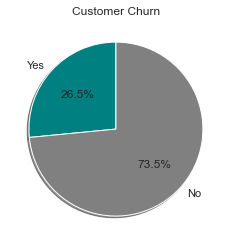

In [165]:
labels = 'Yes','No'

sizes = [len(df[df['Churn_Value']==1])/len(df)*100,len(df[df['Churn_Value']==0])/len(df)*100]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90,colors= ['teal','grey'])
ax1.set(aspect = 'equal',title = 'Customer Churn')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [75]:
df.iloc[:,:-1].describe()

#The table above shows summary statistics for the numerical features in our dataset.

,Tenure_Months,Monthly_Charges,Total_Charges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [76]:
df.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


In [81]:
diff = (df.Tenure_Months*df.Monthly_Charges - df.Total_Charges)

In [223]:
sum(df.Streaming_Movies == df.Streaming_TV)

5484

In [166]:
def Numerical_distribution(df,feature):
    
    """ Distribution of numerical variable based on target variable"""
    
    fig = plt.figure(figsize=(9,6))
    
    plt.subplot(2,1,1)
    ax = sns.kdeplot(df[feature], color = 'black',shade = True)
    plt.title(f'Distribution of {feature}')
    
    plt.subplot(2,1,2)
    ax = sns.kdeplot(df.loc[(df['Churn_Value']==1),feature], color = 'teal', label='Chrun',shade = True)

    ax = sns.kdeplot(df.loc[(df['Churn_Value']==0) ,feature], color = 'grey', label='No chrun',shade = True)
    
    plt.title(f'{feature}: Churn vs No churn')
    plt.legend()
    plt.tight_layout()
    plt.show()

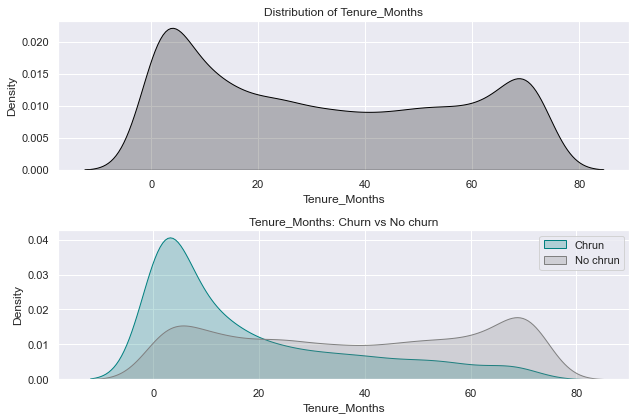

In [167]:
Numerical_distribution(df,'Tenure_Months')

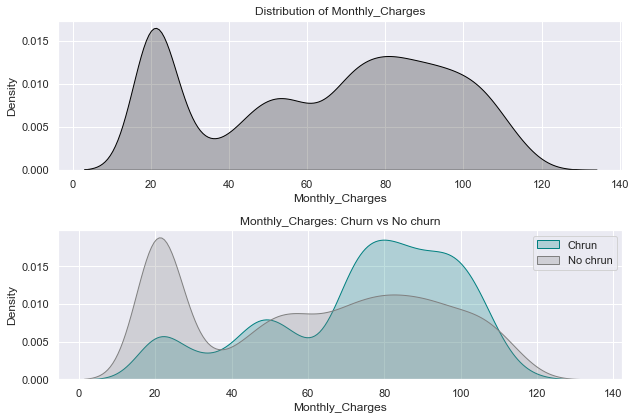

In [168]:
Numerical_distribution(df,'Monthly_Charges')

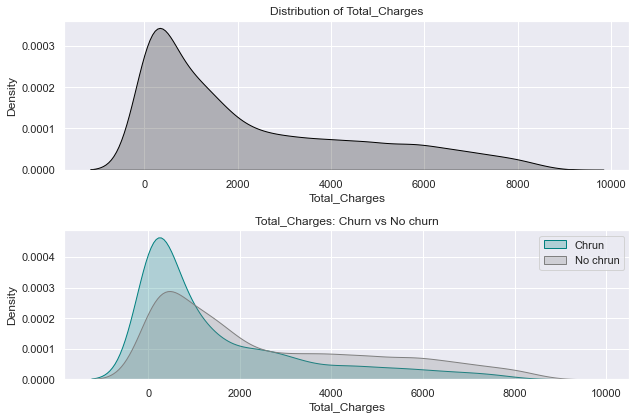

In [169]:
Numerical_distribution(df,'Total_Charges')

<Figure size 648x648 with 0 Axes>

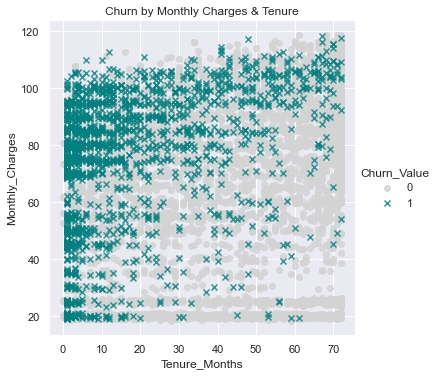

In [208]:
fig = plt.figure(figsize=(9,9))
sns.lmplot(x='Tenure_Months'
           ,y='Monthly_Charges'
           ,data=df
           ,hue='Churn_Value'
            ,fit_reg=False
            ,markers=["o", "x"]
            ,palette= ['lightgrey','teal'])
plt.title('Churn by Monthly Charges & Tenure')
plt.show()

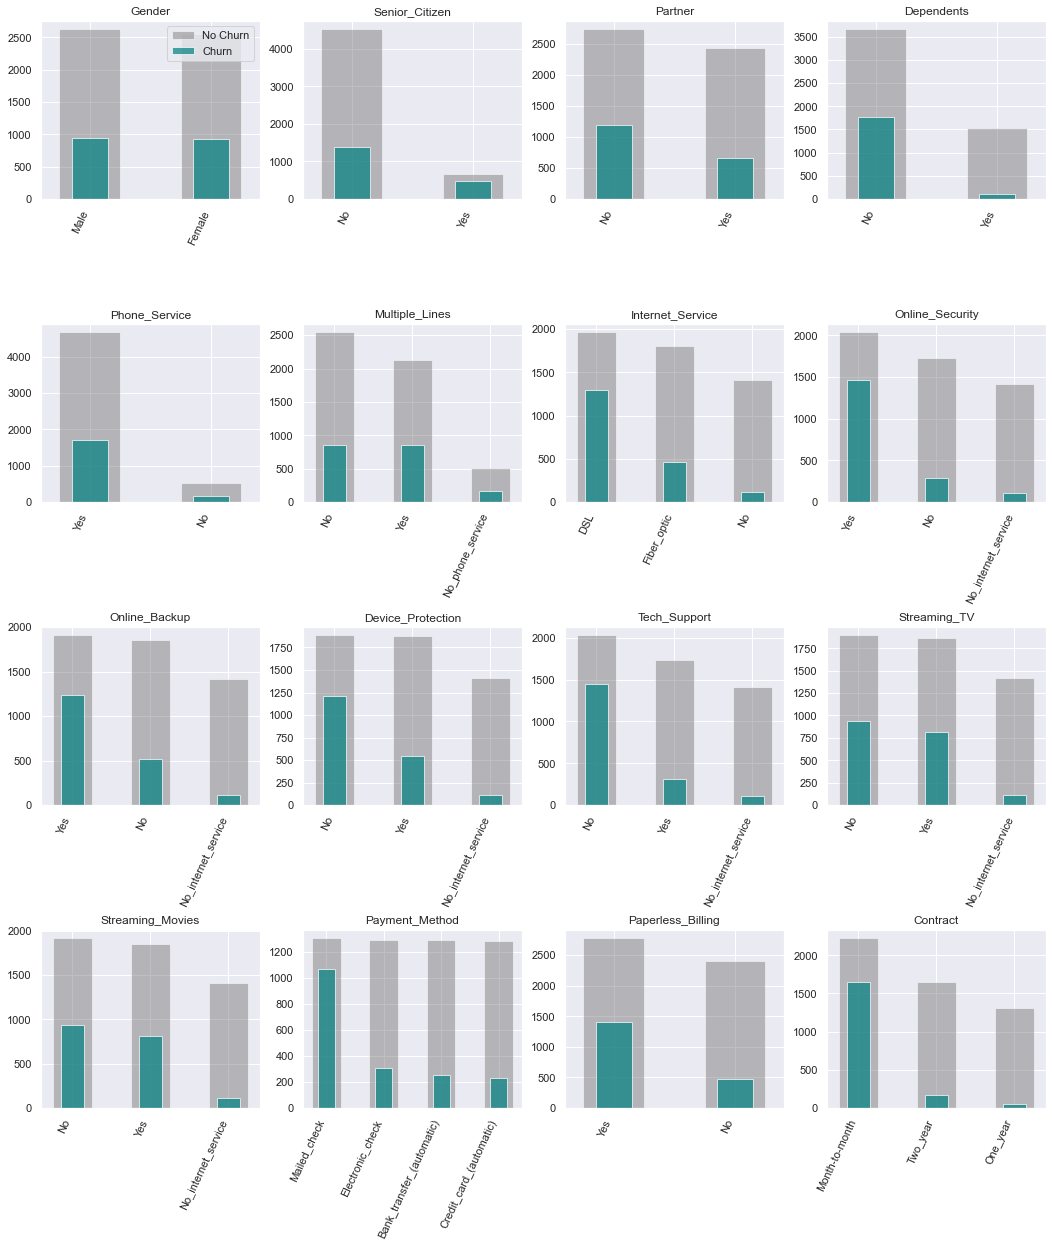

In [199]:
categorical_features = [
 'Gender',
 'Senior_Citizen',
 'Partner',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Internet_Service',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Payment_Method',
 'Paperless_Billing',
 'Contract' ]

ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 20) )

row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS

    df[df['Churn_Value']==0][categorical_feature].value_counts().plot(kind = 'bar', 
                width=.5, ax=ax[row, col], color='grey', alpha=0.5).set_title(categorical_feature)

    df[df['Churn_Value']==1][categorical_feature].value_counts().plot(kind ='bar', 
                width=.3, ax=ax[row, col], color='teal', alpha=0.7).set_title(categorical_feature)

    ax[0, 0].legend(['No Churn', 'Churn'])
    ax[row, col].set_xticklabels(rotation= 65, horizontalalignment = 'right',labels=df[categorical_feature].unique().tolist())
    fig.subplots_adjust(hspace=0.7)
    



From above analysis, churn customers are likely to

not have partners and Dependents; Means likely to be Single.
have Internet service and specifically Fiber optics
not have online security service, online backup service, device protection service, Tech support service
have streaming TV and streaming Movies services
be with monthly based contract
have paperless billing service
have electronic check payment method

# Categorical Correlation - Cramer's V

I am looking for a measure of association between two categorical features. Cramer’s V. It is based on a nominal variation of Pearson’s Chi-Square Test.

Similarly to correlation, but unlike correlation, there are no negative values, as there’s no such thing as a negative association because it's based on 'value_counts'.

In [211]:
from scipy.stats import chi2_contingency
def cramers_v(x, y):
    cm = pd.crosstab(x,y)
    chi2 = chi2_contingency(cm)[0]
    n = cm.sum().sum()
    phi2 = chi2/n
    r,k = cm.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def object_to_int(dataframe):
    if dataframe.dtype=='object':
        dataframe = LabelEncoder().fit_transform(dataframe)
    return dataframe

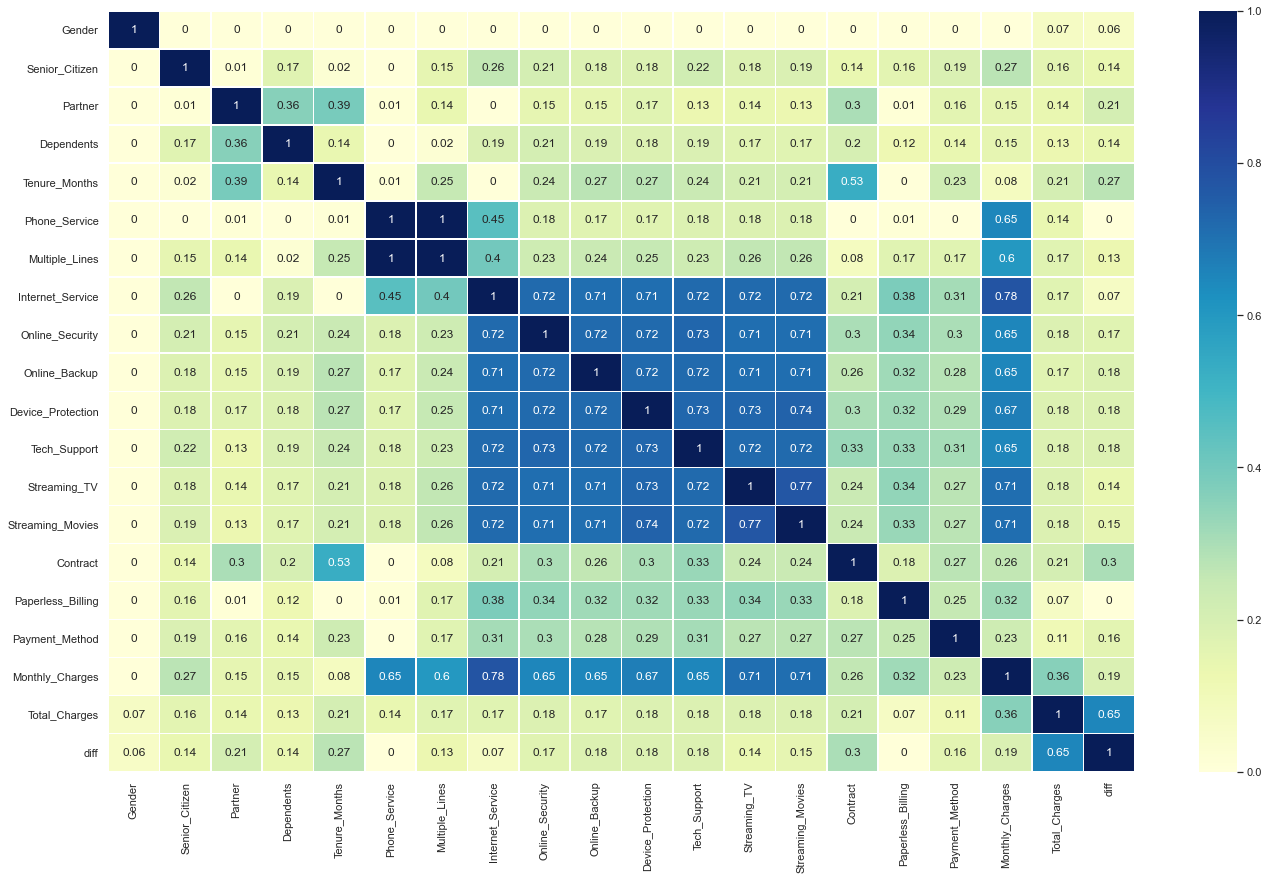

In [212]:
lst = ['Churn_Value']
df_en = df1.drop(lst,axis=1)
df_encoded = df_en.apply(lambda x: object_to_int(x))

rows= []
co = df_encoded.columns.to_list()
for var1 in co:
    col = []
    for var2 in co:
        cramers = cramers_v(df_encoded[var1], df_encoded[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
df_corr = pd.DataFrame(cramers_results, columns = co, index =co)

f, ax = plt.subplots(figsize =(23, 14))
sns.heatmap(df_corr, ax = ax, cmap ="YlGnBu", linewidths = 0.5, annot=True)
plt.show()
plt.title('Correlation of Features')

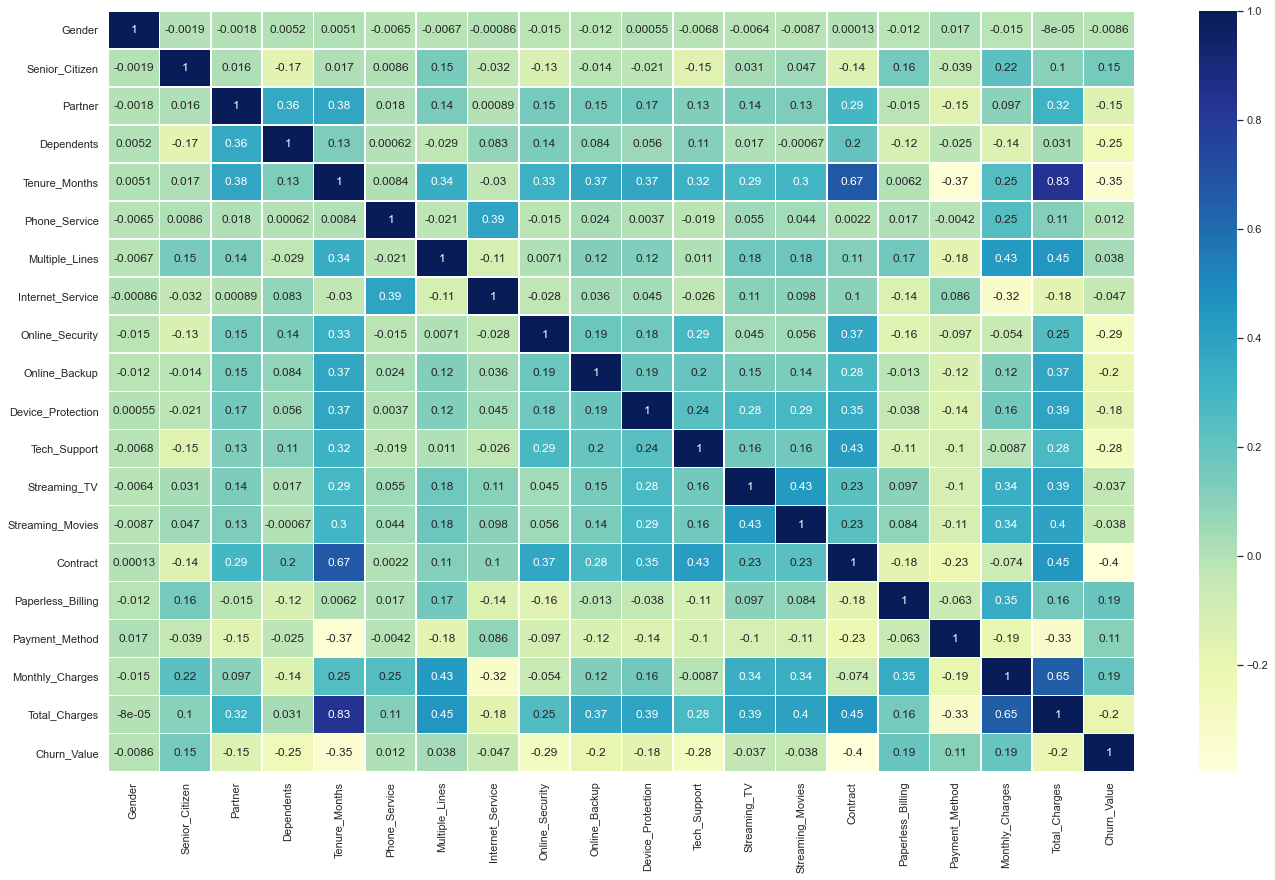

In [213]:
df_enc = df1.iloc[:,:-1].apply(lambda x: object_to_int(x))
corrmat = df_enc.corr()
f, ax = plt.subplots(figsize =(23, 14))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.5, annot=True)
plt.show()

Imagine the simplest method of upsampling. Let's say every data point is "copied" 6 times. It isn't hard to imagine that in 3-fold validation, a typical folding has (on average) 2 copies of each point in each fold. If the classifier memories the test set, the validation set will get a perfect score because the validation set has no new data points! I made this mistakes before.

Instead, we should split into training and validation folds. Then, on each fold, we should upsample the minority class

Train the classifier on the training folds

Validate the classifier on the remaining fold

In [15]:
df1 = df.copy(deep=True)

In [16]:
df1.head(10)

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1
5,Female,No,Yes,No,10,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),55.20,528.35,1
6,Male,Yes,No,No,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,1
7,Male,No,No,No,1,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.15,20.15,1
8,Male,No,Yes,Yes,47,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.35,4749.15,1
9,Male,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.20,30.20,1


In [17]:
# df1.Senior_Citizen = df1.Senior_Citizen.replace({"Male":"Yes", "Female":"No"})

# Replace "No internet service" with "No"
internet_cols = ['Online_Security', 'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies']
for x in internet_cols:
    df1[x] = df1[x].replace({'No internet service' : 'No'})

# Replace "No phone service" with "No"
df1.Multiple_Lines = df1.Multiple_Lines.replace({'No phone service' : 'No'})

In [18]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             7043 non-null   object 
 1   Senior_Citizen     7043 non-null   object 
 2   Partner            7043 non-null   object 
 3   Dependents         7043 non-null   object 
 4   Tenure_Months      7043 non-null   int64  
 5   Phone_Service      7043 non-null   object 
 6   Multiple_Lines     7043 non-null   object 
 7   Internet_Service   7043 non-null   object 
 8   Online_Security    7043 non-null   object 
 9   Online_Backup      7043 non-null   object 
 10  Device_Protection  7043 non-null   object 
 11  Tech_Support       7043 non-null   object 
 12  Streaming_TV       7043 non-null   object 
 13  Streaming_Movies   7043 non-null   object 
 14  Contract           7043 non-null   object 
 15  Paperless_Billing  7043 non-null   object 
 16  Payment_Method     7043 

In [19]:
yes_no_map = {"Male":'Yes',"Female":'No'}

df1['Gender'] = df1['Gender'].apply(lambda x: x.replace("Male",'Yes'))
df1['Gender'] = df1['Gender'].apply(lambda x: x.replace("Female",'No'))

In [20]:
df1.head(10)

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Yes,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,No,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,No,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
3,No,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Yes,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1
5,No,No,Yes,No,10,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Credit card (automatic),55.20,528.35,1
6,Yes,Yes,No,No,1,No,No,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,39.65,1
7,Yes,No,No,No,1,Yes,No,No,No,No,No,No,No,No,Month-to-month,No,Mailed check,20.15,20.15,1
8,Yes,No,Yes,Yes,47,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.35,4749.15,1
9,Yes,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.20,30.20,1


In [21]:
cate_features=df1.describe(include=[object]).loc['unique']
binary_features = cate_features[cate_features == 2].index.tolist()

In [22]:
binary_features

['Gender',
 'Senior_Citizen',
 'Partner',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Paperless_Billing']

In [23]:
yes_no_map = {'Yes':1,'No':0}
y = df1['Churn_Value']
df1[binary_features] = df1[binary_features].apply(lambda x: x.map(yes_no_map),axis = 1)
df2 = df1.drop('Churn_Value',axis=1)
X = pd.get_dummies(df2)


In [155]:
data = pd.read_csv('data_with_clusters.csv')
data.head()

,Unnamed: 0,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,...,Contract_One year,Contract_Two year,Payment_Method_Bank transfer (automatic),Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check,x_kpca_rbf,y_kpca_rbf,z_kpca_rbf,cluster_kpca_rbf
0,0,1,0,0,0,2,1,0,1,1,...,0,0,0,0,0,1,0.118618,0.132102,0.378523,3
1,1,0,0,0,1,2,1,0,0,0,...,0,0,0,0,1,0,-0.088538,0.410178,-0.018236,1
2,2,0,0,0,1,8,1,1,0,0,...,0,0,0,0,1,0,-0.280183,0.174737,-0.157860,1
3,3,0,0,1,1,28,1,1,0,0,...,0,0,0,0,1,0,-0.280957,-0.015741,-0.142610,1
4,4,1,0,0,1,49,1,1,0,1,...,0,0,1,0,0,0,-0.226924,-0.133839,-0.094460,0


In [136]:
index_cluster1[:100]

array([  2,   3,   4,   8,  12,  13,  15,  23,  24,  25,  27,  30,  39,
        40,  41,  48,  50,  64,  70,  80,  81,  82,  86,  87,  88,  96,
       100, 102, 110, 113, 121, 125, 127, 132, 135, 142, 148, 150, 152,
       153, 154, 155, 170, 181, 191, 195, 196, 199, 201, 202, 204, 207,
       208, 211, 214, 220, 221, 222, 223, 225, 226, 228, 239, 243, 248,
       250, 260, 273, 279, 283, 287, 290, 293, 296, 303, 305, 310, 320,
       331, 332, 333, 339, 343, 344, 348, 352, 361, 367, 368, 369, 370,
       376, 382, 386, 389, 390, 400, 405, 407, 413])

In [24]:
X.head()

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Online_Security,Online_Backup,Device_Protection,...,Internet_Service_DSL,Internet_Service_Fiber optic,Internet_Service_No,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment_Method_Bank transfer (automatic),Payment_Method_Credit card (automatic),Payment_Method_Electronic check,Payment_Method_Mailed check
0,1,0,0,0,2,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,0,1,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
2,0,0,0,1,8,1,1,0,0,1,...,0,1,0,1,0,0,0,0,1,0
3,0,0,1,1,28,1,1,0,0,1,...,0,1,0,1,0,0,0,0,1,0
4,1,0,0,1,49,1,1,0,1,1,...,0,1,0,1,0,0,1,0,0,0


In [25]:
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state = 12,stratify = y)

In [44]:
X.to_csv('churnfeatures.csv',index=False)
y.to_csv('churnlabel.csv',index=False)


In [26]:
X_train.columns

Index(['Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Tenure_Months',
       'Phone_Service', 'Multiple_Lines', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Paperless_Billing', 'Monthly_Charges', 'Total_Charges',
       'Internet_Service_DSL', 'Internet_Service_Fiber optic',
       'Internet_Service_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'Payment_Method_Bank transfer (automatic)',
       'Payment_Method_Credit card (automatic)',
       'Payment_Method_Electronic check', 'Payment_Method_Mailed check'],
      dtype='object')

# RandomForest

In [522]:
rf = RandomForestClassifier(random_state=12)

param_grid = {'n_estimators':[500,1000],
             'max_depth':[4,5,6],
             'bootstrap':[True], 'class_weight':[{1:w} for w in [1,2,3]] }

rfclf = GridSearchCV(rf,param_grid= param_grid,scoring = 'recall', cv=3)
rfclf.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12),
             param_grid={'bootstrap': [True],
                         'class_weight': [{1: 1}, {1: 2}, {1: 3}],
                         'max_depth': [4, 5, 6], 'n_estimators': [500, 1000]},
             scoring='recall')

In [530]:
rfclf.best_estimator_

RandomForestClassifier(class_weight={1: 3}, max_depth=4, n_estimators=1000,
                       random_state=12)

In [531]:
pred = rfclf.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('precision',precision_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))

f1-score: 0.640983606557377
recall 0.8372591006423983
precision 0.5192563081009296
roc_auc: 0.7787531979255269


# XGBoost

In [438]:
# Since optimization takes time, run it sequantially on a subset of potiential parameters.

param_grid = {'max_depth': [3,4,5],
             'learning_rate': [0.1,0.05,0.01],
             'gamma':[0,0.25,0.1],
             'reg_lambda':[0,1.0,10.0],
             'scale_pos_weight':[3]}

# Param_grid = {'max_depth': [3,4,5,6],
#              'learning_rate': [0.1,0.05,0.01,0.001],
#              'gamma':[0,0.25,0.1],
#              'reg_lambda':[0,1.0,10.0],
#              'scale_pos_weight':[1,3,5]}


# 3 - folds
# a random 90% of subset of the data 
# 70% features for each tree


optimal_param2 = GridSearchCV(estimator= xgb.XGBClassifier(objective= 'binary:logistic',
                                                         seed = 12, subsample = 0.9,
                                                         colsample_bytree = 0.7,use_label_encoder=False),
                            param_grid= param_grid,verbose= 0, n_jobs= 10, cv=3,scoring= 'recall')

optimal_param2.fit(X_train, y_train)

[15:39:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.7, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=12,
                                     subsample=0.9, tree_method=

In [439]:
optimal_param2.best_params_

{'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'reg_lambda': 0,
 'scale_pos_weight': 3}

In [523]:
clf_xgb2 = xgb.XGBClassifier(seed = 12, objective = 'binary:logistic', gamma = 0.1,learning_rate = 0.05,
                            max_depth = 3, scale_pos_weight = 3, reg_lambda = 0 , use_label_encoder=False,
                             subsample = 0.9,colsample_bytree = 0.5,verbose = True)
clf_xgb2.fit(X_train,y_train)

[19:15:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:15:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=12,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=3, seed=12,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbose=True, verbosity=None)

In [441]:
pred = clf_xgb2.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('precision',precision_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))

f1-score: 0.6578293289146644
precision 0.5364864864864864
recall 0.8501070663811563
roc_auc: 0.7925187573018609


# LGBM

In [542]:
# Since optimization takes time, run it sequantially on a subset of potiential parameters.

param_grid = {'max_depth': [3,4,5],
             'num_leaves':[3,4,5,6,8,10],
             'scale_pos_weight':[2.76,3],
             'subsample_freq':[5,8,10],
             'learning_rate':[0.01,0.025,0.05,0.1,0.15],
             'n_estimators':[100,200,300],
             'max_bin':[10,20,30]}

# Param_grid = {'max_depth': [3,4,5,6],
#              'learning_rate': [0.1,0.05,0.01,0.001],
#              'gamma':[0,0.25,0.1],
#              'reg_lambda':[0,1.0,10.0],
#              'scale_pos_weight':[1,3,5]}


# 3 - folds
# a random 90% of subset of the data 
# 70% features for each tree


optimal_param3 = GridSearchCV(estimator= LGBMClassifier(objective= 'binary',verbosity=0,
                                                         seed = 12, subsample = 0.8,
                                                         colsample_bytree = 0.7),
                            param_grid= param_grid,verbose= 0, n_jobs= 10, cv=3,scoring= 'recall')

optimal_param3.fit(X_train, y_train)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


GridSearchCV(cv=3,
             estimator=LGBMClassifier(colsample_bytree=0.7, objective='binary',
                                      seed=12, subsample=0.8, verbosity=0),
             n_jobs=10,
             param_grid={'learning_rate': [0.01, 0.025, 0.05, 0.1, 0.15],
                         'max_bin': [10, 20, 30], 'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [3, 4, 5, 6, 8, 10],
                         'scale_pos_weight': [2.76, 3],
                         'subsample_freq': [5, 8, 10]},
             scoring='recall')

In [543]:
optimal_param3.best_estimator_

LGBMClassifier(colsample_bytree=0.7, learning_rate=0.025, max_bin=10,
               max_depth=5, n_estimators=200, num_leaves=6, objective='binary',
               scale_pos_weight=3, seed=12, subsample=0.8, subsample_freq=8,
               verbosity=0)

In [206]:
# lgb = LGBMClassifier(colsample_bytree=0.7, learning_rate=0.05, max_bin=50,
#                max_depth=3, num_leaves=10, objective='binary',
#                scale_pos_weight=3, seed=12, subsample=0.9, subsample_freq=5,
#                verbosity=0)
lgb = LGBMClassifier(colsample_bytree=0.7, learning_rate=0.025, max_bin=10,
               max_depth=10, n_estimators=200, num_leaves=5, objective='binary',
               scale_pos_weight=3, seed=12, subsample=0.9, subsample_freq=8,
               verbosity=0)

lgb.fit(X_train,y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


LGBMClassifier(colsample_bytree=0.7, learning_rate=0.025, max_bin=10,
               max_depth=10, n_estimators=200, num_leaves=5, objective='binary',
               scale_pos_weight=3, seed=12, subsample=0.9, subsample_freq=8,
               verbosity=0)

In [6]:
pred = lgb.predict(X_test)
print('f1-score:', f1_score(y_test,pred))
print('precision',precision_score(y_test,pred))
print('recall',recall_score(y_test,pred))
print('roc_auc:',roc_auc_score(y_test,pred))

f1-score: 0.6547522339561331
precision 0.5274869109947644
recall 0.8629550321199143
roc_auc: 0.7919875624278087


Text(0.5, 440.31090909090915, 'Predicted Values')

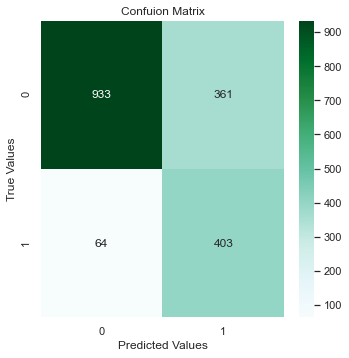

In [7]:
conf_matrix = confusion_matrix(y_test,pred)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='BuGn')
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


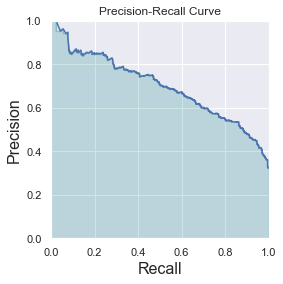

In [89]:
from sklearn.metrics import precision_recall_curve
y_prob = lgb.predict_proba(X_test)
precision,recall,thresholds = precision_recall_curve(y_test, y_prob[:,1])
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]


plt.figure()
step_kwargs = ({'step': 'post'})
plt.step(recall, precision, color='teal', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='teal', **step_kwargs)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.plot(recall, precision)
plt.ylabel('Precision', fontsize=16)
plt.xlabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.title('Precision-Recall Curve')
plt.show()


Text(0.5, 1.0, 'Churn probability distribution')

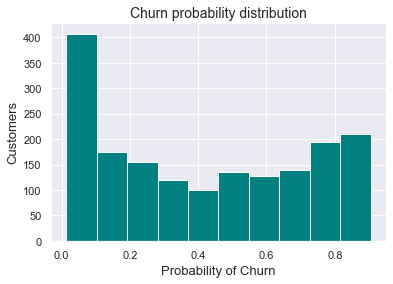

In [92]:
plt.hist( y_prob[:,1], bins = 10,color='teal')

plt.xlabel("Probability of Churn", fontsize=13)
plt.ylabel("Customers", fontsize=13)

plt.title("Churn probability distribution", fontsize=14)

# Upsampling and other models

In [35]:
X = pd.read_csv('churnfeatures.csv')
y = pd.read_csv('churnlabel.csv')
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state = 12,stratify = y)

In [36]:
from imblearn.over_sampling import SMOTE



from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

import eli5
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
sns.set()



recall LogReg: 0.651116 (+/- 0.028922)
recall SVC: 0.619462 (+/- 0.032426)
recall KNN: 0.614550 (+/- 0.019400)
recall GradientBoostingClassifier: 0.655975 (+/- 0.008484)
recall ExtraTreesClassifier: 0.617622 (+/- 0.015943)
[17:06:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:06:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. E

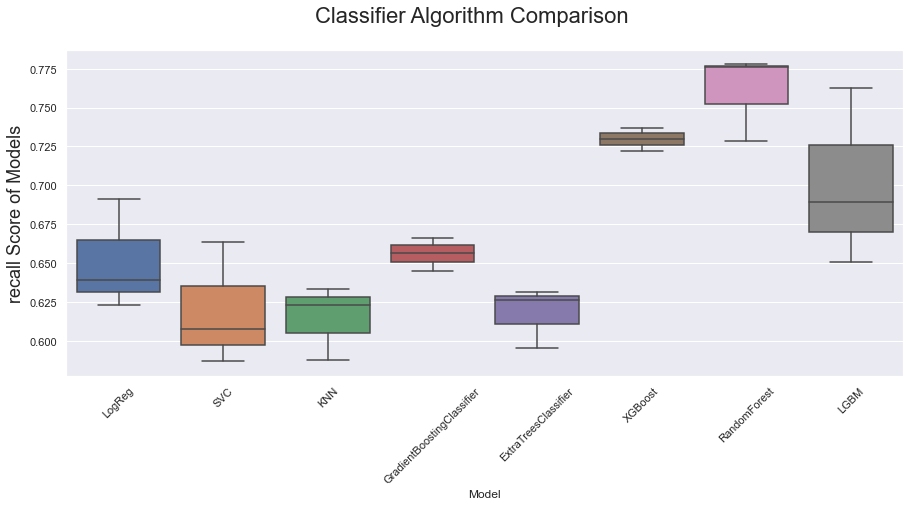

In [39]:
# pipeline for a simple experiment

clfs = []


clfs.append(("LogReg", 
             Pipeline([("Scaler",StandardScaler()),
                       ("LogReg", LogisticRegression(C=0.5,random_state=42))])))

clfs.append(("SVC", 
             Pipeline([("Scaler",StandardScaler()),
                       ("SVC", SVC(kernel = 'rbf', class_weight= 'balanced',random_state=42))]))) 
clfs.append(("KNN", 
             Pipeline([("Scaler", StandardScaler()),
                       ("KNN", KNeighborsClassifier(n_neighbors=8))]))) 

clfs.append(("GradientBoostingClassifier", 
             Pipeline([
                       ("GradientBoosting", GradientBoostingClassifier(max_features=0.7, 
                                                                       n_estimators=200,
                                                                      max_depth=5,
                                                                      learning_rate=0.025,
                                                                      random_state=42))])))

clfs.append(("ExtraTreesClassifier", 
             Pipeline([("Scaler", StandardScaler()),
                       ("ExtraTreesClassifier", ExtraTreesClassifier(max_features = 0.7,
                                                                     min_samples_leaf = 5,
                                                                    n_estimators=200,
                                                                    min_samples_split = 8,
                                                                    random_state = 42,
                                                                    n_jobs = -1))])))



clfs.append(("XGBoost",
             Pipeline([("XGBoost",xgb.XGBClassifier(seed = 12, 
                                                    objective = 'binary:logistic', 
                                                    gamma = 0.1,learning_rate = 0.05,
                                                    max_depth = 3, 
                                                    reg_lambda = 0,
                                                    use_label_encoder=False,
                                                    subsample = 0.9,
                                                    colsample_bytree = 0.5
                                                    ))])))

clfs.append(("RandomForest",
             Pipeline([("RandomForest",RandomForestClassifier(random_state= 12, 
                                                              n_estimators=500,
                                                              max_depth=5,
                                                              bootstrap = True))])))


clfs.append(("LGBM",
             Pipeline([("LGBM",LGBMClassifier(colsample_bytree=0.7,
                                                      learning_rate=0.05, 
                                                      max_bin=10,
                                                       max_depth=3, 
                                                      n_estimators=200, 
                                                      num_leaves=5, 
                                                      objective='binary',
                                                      scale_pos_weight=1,
                                                      seed=12, subsample=0.8, 
                                                      subsample_freq=8,
                                                    verbosity=0,force_col_wise=True))])))



# Using F1 score 
scoring = 'recall'

n_folds = 3

results, names  = [], [] 

for name, model  in clfs:
    
    
    # upsampling for training datasets
    
    cv = KFold(n_splits=n_folds, shuffle= True)

    smoter = SMOTE(random_state = 12)
    scores = []
    for train_fold_index, val_fold_index in cv.split(X_train, y_train):

        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]

        X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
                                                                           y_train_fold)


        model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample) 

        score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
        scores.append(score)
        
    names.append(name)
    results.append(scores)    
    msg = "%s %s: %f (+/- %f)" % (scoring,name, np.mean(scores),np.std(scores))
    print(msg)

# I should improve the code for visualisation 
Score = np.array(results).ravel()
nn = [[i] * 3 for i in names]
nn = np.array(nn).ravel().tolist()
df_re = pd.DataFrame([nn,Score]).T
df_re.columns = ['Model','Score']

# boxplot algorithm comparison
fig = plt.figure(figsize=(15,6))
fig.suptitle('Classifier Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(x='Model', y='Score',data= df_re)
ax.set_xticklabels(names)
ax.set_ylabel("{} Score of Models".format(scoring), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)


plt.show()
